# Exploring Gender Bias in 1973 UC Berkeley Graduate Admissions

Group 3: Alex Haddon, Kashish Joshipura, Nusaibah Hossain, Euna Ao

### Introduction


<figure style="text-align:center;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a1/Seal_of_University_of_California%2C_Berkeley.svg/1200px-Seal_of_University_of_California%2C_Berkeley.svg.png" width="200" height="200">
    <figcaption> <i> University of California, Berkeley Seal </i> </figcaption>
</figure>



The 1973 Berkeley Dataset contains 12.763 applicants who applied to UC-Berkeley graduate programs and their respective major, gender, and admission status.

This dataset is part of ongoing discourse regarding gender bias in university admissions. A 2002 study conducted in Israel found that admissions scores were a fair, unbiased predictor of first year performance (Azen et al., 2002). Similarly, a 2017 study found that there was equal probability of admittance across all genders (Bhattacharya et al., 2017). However, we know that in that time period there existed discrimation against non-males. 

Dataset Size: 12,763 rows × 4 columns

Dataset Variables:

|Variable|Type|Notes|
|--------|----|-----|
|Year|int|The application year (this data is always 1973)|
|Major|str|An anonymized major code (either A, B, C, D, E, F, or Other). The specific majors are unknown except that A-F are the six majors with the most applicants in Fall 1973|
|Gender|str|Applicant self-reported gender (either M or F)|
|Admission|str|Admission decision (either Rejected or Accepted)|





#### Research Question

As our population is all applicants, our parameter of interest is the difference of proportion for the proportions of male and female students admitted. Our research question is: **"is there indication of gender-based discrimination for UC-Berekely admissions in 1973?"**

We will perform two two-tailed hypothesis tests for difference on proportions - one being theory based and the other using bootstrap distribution. 

#### Hypothesis

We are investigating whether there existed gender discrimination in graduate admissions between male and female applicants. Our null hypothesis therefore would be that there existed no such discrimination and the proportion of males admitted minus the proportion of females admitted would be equal to zero. 

$H_0 : p_m - p_f = 0$

Our alternative hypothesis is that such a difference did exist and therefore the difference in proportions would be greater than zero and men were favored in admissions. 

$H_a : p_m - p_f  > 0$


#### Significance

We will test at 95% confidence level or 5% significance level. This is a standardly accepted in the scientific community as thelevel used to determine statistical significance. 

### Preliminary Results

In [44]:
# Load required packages
library(plyr)
library(tidyverse)
library(infer)
library(repr)
library(stringr)
library(broom)

In [45]:
set.seed(2023)

#for future analysis, we will set the seed to ensure reproducibility

In [55]:
# Reading the dataset
url <- "https://raw.githubusercontent.com/kashish1928/STAT201_Group_03/main/data/berkeley.csv"
admission_data_raw <- read.csv(url)

head(admission_data_raw)

,Year,Major,Gender,Admission
,<int>,<chr>,<chr>,<chr>
1,1973,C,F,Rejected
2,1973,B,M,Accepted
3,1973,Other,F,Accepted
4,1973,Other,M,Accepted
5,1973,Other,M,Rejected
6,1973,Other,M,Rejected


In [56]:
#Rename Columns
new_col_names <- c("year", "major", "gender", "admission")
admission_data <- rename(admission_data_raw, !!!setNames(names(admission_data_raw), new_col_names)) %>%
select(gender, admission)

admission_data_updated <- na.omit(admission_data)
head(admission_data_updated)

,gender,admission
,<chr>,<chr>
1,F,Rejected
2,M,Accepted
3,F,Accepted
4,M,Accepted
5,M,Rejected
6,M,Rejected


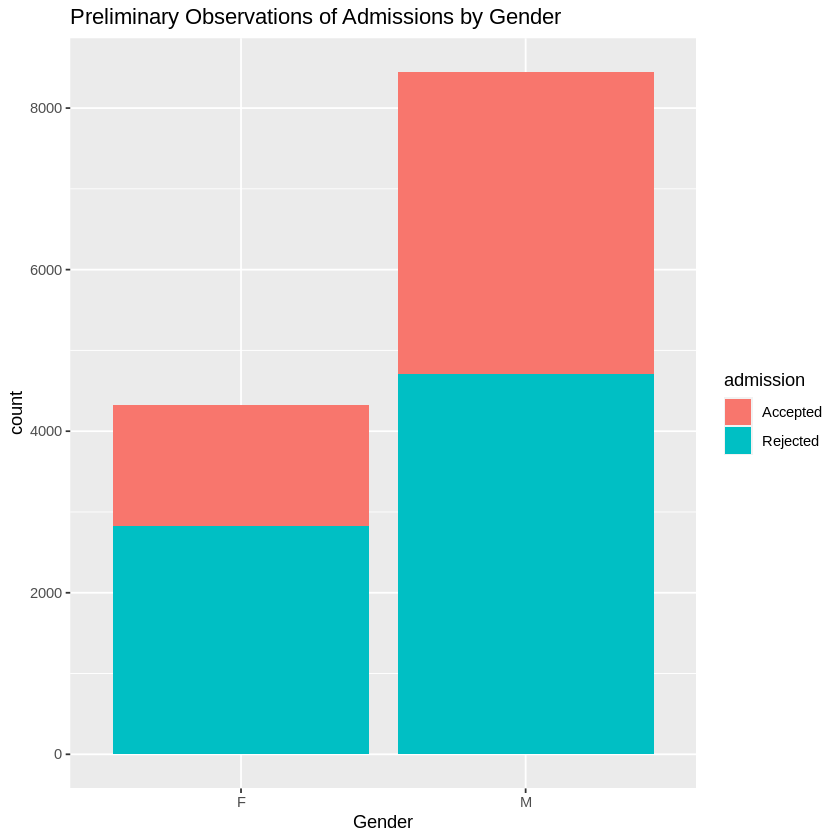

In [57]:
gender_admission_plot <- admission_data_updated |>
    ggplot(aes(x = gender, fill = admission)) +
    geom_bar() +
    labs(title = "Preliminary Observations of Admissions by Gender",
         x = "Gender")

gender_admission_plot

In [64]:
# Admission Counts by Gender
admission_summary <- admission_data_updated |>
    group_by(gender, admission) |>
    summarise(count = n()) |>
    mutate(total = sum(count), prop = count/total) 

head(admission_summary)   

`summarise()` has grouped output by 'gender'. You can override using the
`.groups` argument.


gender,admission,count,total,prop
<chr>,<chr>,<int>,<int>,<dbl>
F,Accepted,1494,4321,0.3457533
F,Rejected,2827,4321,0.6542467
M,Accepted,3738,8442,0.4427861
M,Rejected,4704,8442,0.5572139


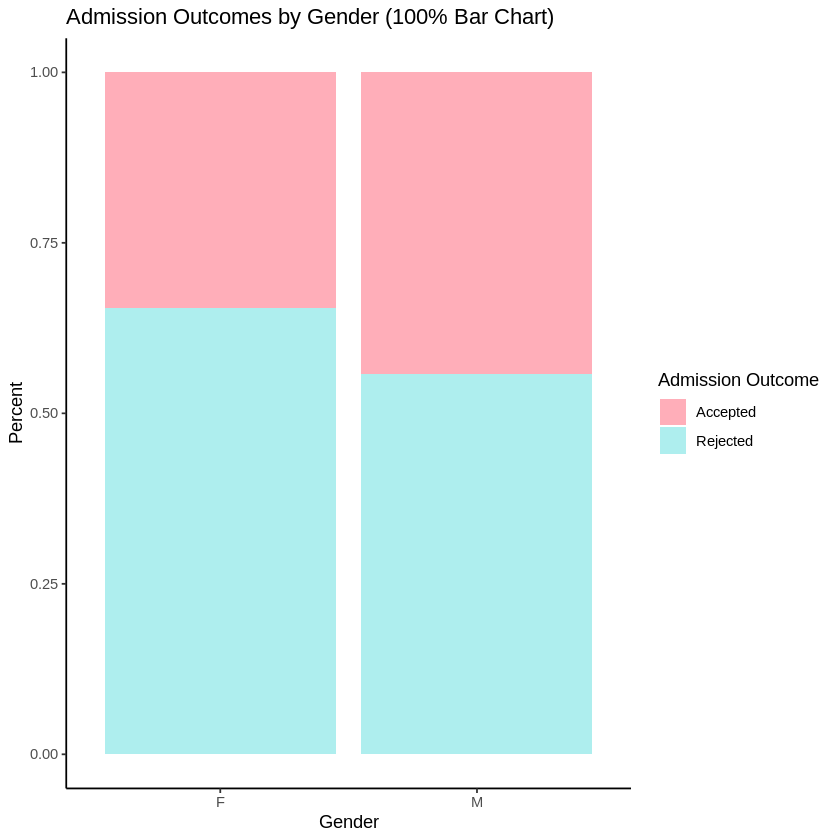

In [66]:

# Create a stacked bar chart
ggplot(admission_summary, aes(x = gender, y = prop, fill = admission)) +
  geom_bar(stat = "identity") +
  labs(title = "Admission Outcomes by Gender (100% Bar Chart)",
       x = "Gender",
       y = "Percent",
       fill = "Admission Outcome") +
  scale_fill_manual(values = c("lightpink1", "paleturquoise2")) +
  theme_classic()


In [67]:
# Observed Proportion of Admitted Female students 
p_hat_female <- admission_counts$count[1] / admission_counts$total[1]

# Observed Proportion of Admitted Male students
p_hat_male <- admission_counts$count[3] / admission_counts$total[3]


# Observed Difference in Proportions
obs_difference <- p_hat_male - p_hat_female

# Total Number of Observations
n_pooled <- admission_counts$total[1] + admission_counts$total[3]

# Pooled Proportion
p_hat_pooled <- (p_hat_male*admission_counts$total[3] + p_hat_female*admission_counts$total[1])/
                (admission_counts$total[3]+admission_counts$total[1])

In [68]:
# Test For Feasibility of Normal Approximation
n_pooled*p_hat_pooled
n_pooled*(1-p_hat_pooled)

[1] 5232

[1] 7531

In [71]:
# Observed Statistics Table

obs_stats <- admission_summary %>%
filter(admission == "Accepted") %>%
select(-admission) %>%
rename(p_hat = prop) %>%
pivot_wider(names_from = gender, values_from = c(count, total, p_hat)) %>%
mutate(p_hat_pooled = p_hat_pooled, obs_prop_difference = obs_difference)

obs_stats

count_F,count_M,total_F,total_M,p_hat_F,p_hat_M,p_hat_pooled,obs_prop_difference
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1494,3738,4321,8442,0.3457533,0.4427861,0.409935,0.09703277


Our observed difference in proportions is : **0.0970327718040209 (9.7%)**


## Methods


##### Theory Based Hypothesis Test

We verify that our data meets the sample size condition such that  𝑛𝑝̂ ≥10 and  𝑛(1−𝑝̂ )≥10. This ensures that our sampling distribution under  𝐻0 of the test statistic  𝑍 is approximately  𝑁(0,1). 

To ensure the normally distributed null model, we will calculate the pooled proportion. 

$\widehat p = \frac{n_{male}*\widehat p_{male} + n_{female}*\widehat p_{female}}{n_{male} + n_{female}}$

We can then calculate the Z test statistic as our null model is approximately normal. 

$Z = \frac{\widehat p_{male} - \widehat p_{female}}{\sqrt{\widehat p*(1-\widehat p))*(\frac{1}{n_{male}} + \frac{1}{n_{female}})}}$


We will then compare the prop.test p values with the varying significance levels and either reject or fail to reject the null hypothesis. 

95% confidence interval centered around the observed difference in proportions will be constructed and then compared to the null hypothesis. 

##### Bootstrapping

A hypothesis test via bootstrapping using the `infer` package will also be performed. Our response variable is `admission` while the explanatory variable is `gender`. Using the same null and alternative hypothesis, we will bootstrap for 1000 reps and construct a 95% confidence interval.




In [ ]:
bootstrap_null <- admission_data_updated |>
                            specify(formula=admission ~ gender, success= "Accepted")|>
                            hypothesize(null='independence')|>
                            generate(reps=1000, type='permute')|>
                            calculate(stat='diff in props', order = c('M', 'F'))
head(bootstrap_null)

replicate,stat
<int>,<dbl>
1,-0.0110811532
2,-0.0016343054
3,-0.0047832547
4,-0.0107312700
5,-0.0005846557
6,-0.0138802193


In [ ]:

obs_diff_in_props <-admission_data_updated |>
                            specify(formula=admission ~ gender, success= "Accepted")|>
                            calculate(stat='diff in props', order = c('M', 'F'))
obs_diff_in_props

stat
<dbl>
0.09703277


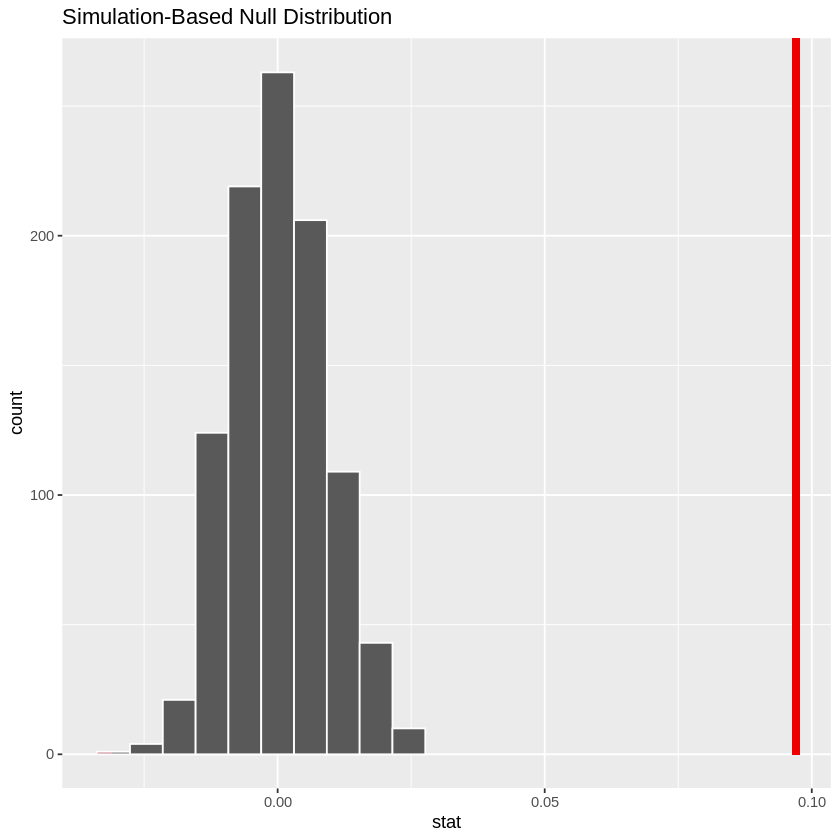

In [ ]:
bootstrap_distribution <-visualize(bootstrap_null, bins =10)+
                shade_p_value(obs_stat=obs_diff_in_props, direction = 'both')
bootstrap_distribution

In [ ]:
p_value <- bootstrap_null |>
            get_p_value(obs_stat=obs_diff_in_props, direction='both')
p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


In [ ]:
classical_prop_test <- tidy(
        prop.test(x = c(obs_stats$count_M[1],obs_stats$count_F[1]), 
                  n = c(obs_stats$total_M[1],obs_stats$total_F[1]), # an array with the size of each sample
                  correct = FALSE)) 
classical_prop_test

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.4427861,0.3457533,111.2497,5.216798e-26,1,0.07933039,0.1147352,2-sample test for equality of proportions without continuity correction,two.sided


### Expect Outcomes & Significance

#### Expected Findings

We expect to find indication of gender-based biases, considering how the 1970s were marked with gender and race inequality (Snipp & Cheung, 2016). Our findings hope to show that these potential biases created unfair admissions that are statistically significant and not caused by chance with various levels of confidence. 

#### Impact of Findings

These findings could help draw attention to the biases admissions have against certain groups of people. An internal review of the admissions process could how they directly/indirectly affect the chance of admissions for these groups of people. 


#### Future Questions

Recent admissions data could be analyzed to see if there are any present biases against minority groups of applicants, such as gender-based bias using the same process we used in our project. 

Additionally, our analysis aggregated all the majors together as the majors were undisclosed. However, we question whether gender-based disparities in admission rates exist between different majors. 


### References

Azen, R., Bronner, S., & Gafni, N. (2002). Examination of Gender Bias in University Admissions. Applied Measurement in Education, 15(1), 75–94. https://doi.org/10.1207/s15324818ame1501_05

Bhattacharya, D., Kanaya, S., & Stevens, M. (2017). Are University Admissions Academically Fair? The Review of Economics and Statistics, 99(3), 449–464. https://doi.org/10.1162/rest_a_00618

Bickel, P. J., Hammel, E. A., & O’Connell, J. W. (1975). Sex Bias in Graduate Admissions: Data from Berkeley. Science, 187(4175), 398–404. https://doi.org/10.1126/science.187.4175.398

Ismay, C., & Kim, A. Y. (2022). Statistical Inference via Data Science. In moderndive.com. Chapman & Hall. https://moderndive.com/

Snipp, C. M., & Cheung, S. Y. (2016). Changes in Racial and Gender Inequality since 1970. The Annals of the American Academy of Political and Social Science, 663, 80–98. http://www.jstor.org/stable/24541901